In [ ]:
!pip install mumin[all]==1.6.2 torchmetrics==0.7.2 --quiet
!pip install dgl-cu111==0.7.2 -f https://data.dgl.ai/wheels/repo.html --quiet
!pip install pickle5

     |████████████████████████████████| 397 kB 13.5 MB/s 
     |████████████████████████████████| 211 kB 86.6 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 4.7 MB 73.5 MB/s 
     |████████████████████████████████| 6.2 MB 25.5 MB/s 
     |████████████████████████████████| 281 kB 55.0 MB/s 
     |████████████████████████████████| 7.4 MB 8.9 MB/s 
     |████████████████████████████████| 93 kB 1.9 MB/s 
     |████████████████████████████████| 81 kB 11.2 MB/s 
     |████████████████████████████████| 6.6 MB 56.9 MB/s 
     |████████████████████████████████| 120 kB 70.4 MB/s 
     |████████████████████████████████| 165.0 MB 34 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 7.0 MB/s 


In [ ]:
from mumin import MuminDataset
from google.colab import drive
from getpass import getpass
from pathlib import Path
import shutil
import re
import pickle5 as pickle
import pandas as pd
import numpy as np

In [ ]:
drive_dir = Path('drive')
drive.mount(str(drive_dir.resolve()), force_remount=True)
drive_content_dir = [child for child in drive_dir.iterdir() 
                     if re.search(r'My ?Drive', str(child.stem)) is not None][0]
shutil.copy(drive_content_dir / 'mumin-small.zip', 'mumin-small.zip')

Mounted at /content/drive


'mumin-small.zip'

In [ ]:
with open ('/content/drive/MyDrive/mumin-small/emb/multilingual_emb_sml_tweet.pkl', 'rb') as f:
    file1 = pd.DataFrame(pickle.load(f))
with open ('/content/drive/MyDrive/mumin-small/emb/text_emb_sml_reply.pkl', 'rb') as f:
    file2 = pd.DataFrame(pickle.load(f))
with open ('/content/drive/MyDrive/mumin-small/emb/multilingual_emb_sml_reply.pkl', 'rb') as f:
    file3 = pd.DataFrame(pickle.load(f))
with open ('/content/drive/MyDrive/mumin-small/emb/text_emb_sml_tweet.pkl', 'rb') as f:
    file4 = pd.DataFrame(pickle.load(f))


In [ ]:
drive_dir = Path('drive')
drive.mount(str(drive_dir.resolve()), force_remount=True)
drive_content_dir = [child for child in drive_dir.iterdir() 
                     if re.search(r'My ?Drive', str(child.stem)) is not None][0]
#shutil.copy(drive_content_dir / 'mumin-small.zip', 'mumin-small.zip')

Mounted at /content/drive


In [ ]:
dataset = MuminDataset('mumin-small.zip')
dataset

MuminDataset(size=small, compiled=False)

In [ ]:
dataset.compile()

INFO:mumin.dataset:Loading dataset


MuminDataset(num_nodes=392,419, num_relations=483,029, size='small', compiled=True)

In [ ]:
from PIL import Image
import itertools as it

<center><img src="https://filedn.com/lRBwPhPxgV74tO0rDoe8SpH/metagraph.png" alt="meta graph of the MuMiN dataset" width="60%"/></center>

In [ ]:
list(dataset.nodes.keys())

['claim', 'tweet', 'user', 'image', 'article', 'hashtag', 'reply']

In [ ]:
from mumin import save_dgl_graph, load_dgl_graph
import dgl
import dgl.nn.pytorch as dglnn
import dgl.dataloading as D
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torchmetrics as tm
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import defaultdict

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [ ]:
if 'dgl_graph' not in globals():
    dgl_graph = dataset.to_dgl()
dgl_graph

INFO:mumin.dataset:Outputting to DGL


Graph(num_nodes={'article': 1497, 'claim': 2127, 'hashtag': 28820, 'image': 1036, 'reply': 186602, 'tweet': 4178, 'user': 158995},
      num_edges={('article', 'has_article_inv', 'tweet'): 1969, ('claim', 'discusses_inv', 'tweet'): 4890, ('hashtag', 'has_hashtag_inv', 'tweet'): 2343, ('hashtag', 'has_hashtag_inv', 'user'): 52420, ('image', 'has_image_inv', 'tweet'): 1045, ('reply', 'posted_inv', 'user'): 186602, ('reply', 'quote_of', 'tweet'): 93926, ('reply', 'reply_to', 'tweet'): 84271, ('tweet', 'discusses', 'claim'): 4890, ('tweet', 'has_article', 'article'): 1969, ('tweet', 'has_hashtag', 'hashtag'): 2343, ('tweet', 'has_image', 'image'): 1045, ('tweet', 'mentions', 'user'): 1134, ('tweet', 'posted_inv', 'user'): 4178, ('tweet', 'quote_of_inv', 'reply'): 93926, ('tweet', 'reply_to_inv', 'reply'): 84271, ('tweet', 'retweeted_inv', 'user'): 13710, ('user', 'follows', 'user'): 19886, ('user', 'follows_inv', 'user'): 19886, ('user', 'has_hashtag', 'hashtag'): 52420, ('user', 'mentions

In [ ]:
print('Node types in the DGL graph:')
print(dgl_graph.ntypes)
print('\nRelation types in the DGL graph:')
dgl_graph.canonical_etypes

Node types in the DGL graph:
['article', 'claim', 'hashtag', 'image', 'reply', 'tweet', 'user']

Relation types in the DGL graph:


[('article', 'has_article_inv', 'tweet'),
 ('claim', 'discusses_inv', 'tweet'),
 ('hashtag', 'has_hashtag_inv', 'tweet'),
 ('hashtag', 'has_hashtag_inv', 'user'),
 ('image', 'has_image_inv', 'tweet'),
 ('reply', 'posted_inv', 'user'),
 ('reply', 'quote_of', 'tweet'),
 ('reply', 'reply_to', 'tweet'),
 ('tweet', 'discusses', 'claim'),
 ('tweet', 'has_article', 'article'),
 ('tweet', 'has_hashtag', 'hashtag'),
 ('tweet', 'has_image', 'image'),
 ('tweet', 'mentions', 'user'),
 ('tweet', 'posted_inv', 'user'),
 ('tweet', 'quote_of_inv', 'reply'),
 ('tweet', 'reply_to_inv', 'reply'),
 ('tweet', 'retweeted_inv', 'user'),
 ('user', 'follows', 'user'),
 ('user', 'follows_inv', 'user'),
 ('user', 'has_hashtag', 'hashtag'),
 ('user', 'mentions', 'user'),
 ('user', 'mentions_inv', 'tweet'),
 ('user', 'mentions_inv', 'user'),
 ('user', 'posted', 'reply'),
 ('user', 'posted', 'tweet'),
 ('user', 'retweeted', 'tweet')]

In [ ]:
plt.figure(figsize=(10, 7))
metagraph = dgl_graph.metagraph()
nx.draw_networkx(metagraph, 
                 pos=nx.shell_layout(metagraph), 
                 node_color='white', 
                 node_size=3000,
                 arrows=False)

In [ ]:
rel = ('user', 'posted', 'tweet')
posted_subgraph = dgl.edge_type_subgraph(dgl_graph, etypes=[rel]).to('cuda')
posted_subgraph

train_mask = posted_subgraph.nodes['tweet'].data['train_mask']
val_mask = posted_subgraph.nodes['tweet'].data['val_mask']
test_mask = posted_subgraph.nodes['tweet'].data['test_mask']

class SAGEClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 500):
        super().__init__()
        user_feats = posted_subgraph.nodes['user'].data['feat'].shape[-1]
        tweet_feats = posted_subgraph.nodes['tweet'].data['feat'].shape[-1]
        self.conv = dglnn.SAGEConv(in_feats=(user_feats, tweet_feats), 
                                   out_feats=hidden_dim, 
                                   aggregator_type='lstm',
                                   activation=nn.GELU())
        self.clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, graph, x):
        x = self.conv(graph, (x['user'], x['tweet']))
        x = self.clf(x)
        return x

gnn = SAGEClassifier().cuda()

def forward_pass() -> dict:
    '''A forward pass of the graph neural network.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Set the GNN to training mode
    gnn.train()

    # Get the input features and the output labels
    input_feats = dict(
        user=posted_subgraph.nodes['user'].data['feat'].float().cuda(),
        tweet=posted_subgraph.nodes['tweet'].data['feat'].float().cuda()
    )
    output_labels = posted_subgraph.nodes['tweet'].data['label'].cuda()

    # Forward propagation
    logits = gnn(posted_subgraph, input_feats).squeeze()

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(
        input=logits[train_mask],
        target=output_labels.float()[train_mask]
    )

    # Compute training metrics
    scores = scorer(logits[train_mask].ge(0), output_labels[train_mask])
    misinformation_f1 = scores[0]
    factual_f1 = scores[1]

    return dict(loss=loss, 
                misinformation_f1=misinformation_f1, 
                factual_f1=factual_f1)
    

def evaluate(split: str) -> dict:
    '''Evaluate the graph neural network.

    Args:
        split (str):
            The split to evaluate the GNN on. Can be 'val' or 'test'.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Get the correct mask, depending on the value of `split`
    mask = val_mask if split == 'val' else test_mask

    gnn.eval()
    with torch.no_grad():

        # Get the input features and the output labels
        input_feats = dict(
            user=posted_subgraph.nodes['user'].data['feat'].float().cuda(),
            tweet=posted_subgraph.nodes['tweet'].data['feat'].float().cuda()
        )
        output_labels = posted_subgraph.nodes['tweet'].data['label'].cuda()

        # Forward propagation
        logits = gnn(posted_subgraph, input_feats).squeeze()

        # Compute validation loss
        val_loss = F.binary_cross_entropy_with_logits(
            input=logits[mask],
            target=output_labels.float()[mask]
        ).cpu().item()

        # Compute validation metrics
        scores = scorer(logits[mask].ge(0), output_labels[mask])
        val_misinformation_f1 = scores[0].cpu().item()
        val_factual_f1 = scores[1].cpu().item()


        true_label = output_labels[mask]
        val_out = nn.Sigmoid()
        val_out = val_out(logits[mask])

    return dict(loss=val_loss, 
                misinformation_f1=val_misinformation_f1, 
                factual_f1=val_factual_f1,
                out=val_out,
                true_label = true_label)


# Initialise optimiser
opt = optim.AdamW(gnn.parameters(), lr=3e-4)

# Initialise scorer
scorer = tm.classification.f_beta.F1Score(num_classes=2, average='none').cuda()

# Initialise dictionary containing validation scores
val_scores = defaultdict(list)

# Initialise progress bar
epoch_pbar = tqdm(range(1000), desc='Training')

for epoch in epoch_pbar:

    # Reset the gradients
    opt.zero_grad()

    # Forward propagation
    train_results = forward_pass()

    # Backward propagation
    train_results['loss'].backward()

    # Update gradients
    opt.step()

    # Evaluate the model
    val_results = evaluate('val')

    # Store the validation scores
    for metric in ['loss', 'misinformation_f1', 'factual_f1']:
        val_scores[metric].append(val_results[metric])

    # Update progress bar description
    if epoch % 25 == 0 and epoch > 0:
        val_loss = np.mean(val_scores['loss'])
        val_misinformation_f1 = np.mean(val_scores['misinformation_f1'])
        val_factual_f1 = np.mean(val_scores['factual_f1'])
        desc = (f'Training - '
                f'loss {train_results["loss"]:.3f} - '
                f'factual_f1 {train_results["factual_f1"]:.3f} - '
                f'misinfo_f1 {train_results["misinformation_f1"]:.3f} - '
                f'val_loss {val_loss:.3f} - '
                f'val_factual_f1 {val_factual_f1:.3f} - '
                f'val_misinfo_f1 {val_misinformation_f1:.3f}')
        epoch_pbar.set_description(desc)
        val_scores = defaultdict(list)

test_results = evaluate('test')
macro_f1 = np.mean([test_results['factual_f1'],
                    test_results['misinformation_f1']])
print('*** Test results ***')
print(f'Factual F1: {test_results["factual_f1"]:.4f}')
print(f'Misinformation F1: {test_results["misinformation_f1"]:.4f}')
print(f'Macro-average F1: {macro_f1:.4f}')


true_label = evaluate('test')['true_label']
user_posted_tweet = evaluate('test')['out']

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

*** Test results ***
Factual F1: 0.2000
Misinformation F1: 0.9442
Macro-average F1: 0.5721


In [ ]:
results = dict()
results['user_posted_tweet'] = user_posted_tweet

In [ ]:
test_results = evaluate('test')
macro_f1 = np.mean([test_results['factual_f1'],
                    test_results['misinformation_f1']])
print('*** Test results ***')
print(f'Factual F1: {test_results["factual_f1"]:.4f}')
print(f'Misinformation F1: {test_results["misinformation_f1"]:.4f}')
print(f'Macro-average F1: {macro_f1:.4f}')

*** Test results ***
Factual F1: 0.1250
Misinformation F1: 0.9518
Macro-average F1: 0.5384


## 'reply', 'reply_to', 'tweet'

In [ ]:
rel = ('reply', 'reply_to', 'tweet')
subgraph = dgl.edge_type_subgraph(dgl_graph, etypes=[rel]).to('cuda')
subgraph

train_mask = subgraph.nodes['tweet'].data['train_mask']
val_mask = subgraph.nodes['tweet'].data['val_mask']
test_mask = subgraph.nodes['tweet'].data['test_mask']

class SAGEClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 500):
        super().__init__()
        feats1 = subgraph.nodes[rel[0]].data['feat'].shape[-1]
        feats2 = subgraph.nodes[rel[2]].data['feat'].shape[-1]
        self.conv = dglnn.SAGEConv(in_feats=(feats1, feats2), 
                                   out_feats=hidden_dim, 
                                   aggregator_type='lstm',
                                   activation=nn.GELU())
        self.clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, graph, x):
        x = self.conv(graph, (x['p1'], x['p2']))
        x = self.clf(x)
        return x

gnn = SAGEClassifier().cuda()
gnn

def forward_pass() -> dict:
    '''A forward pass of the graph neural network.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Set the GNN to training mode
    gnn.train()

    # Get the input features and the output labels
    input_feats = dict(
        p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
        p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
    )
    output_labels = subgraph.nodes['tweet'].data['label'].cuda()

    # Forward propagation
    logits = gnn(subgraph, input_feats).squeeze()

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(
        input=logits[train_mask],
        target=output_labels.float()[train_mask]
    )

    # Compute training metrics
    scores = scorer(logits[train_mask].ge(0), output_labels[train_mask])
    misinformation_f1 = scores[0]
    factual_f1 = scores[1]

    return dict(loss=loss, 
                misinformation_f1=misinformation_f1, 
                factual_f1=factual_f1)

def evaluate(split: str) -> dict:
    '''Evaluate the graph neural network.

    Args:
        split (str):
            The split to evaluate the GNN on. Can be 'val' or 'test'.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Get the correct mask, depending on the value of `split`
    mask = val_mask if split == 'val' else test_mask

    gnn.eval()
    with torch.no_grad():

        # Get the input features and the output labels
        input_feats = dict(
            user=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
            tweet=subgraph.nodes[rel[2]].data['feat'].float().cuda()
        )
        output_labels = subgraph.nodes['tweet'].data['label'].cuda()

        # Forward propagation
        logits = gnn(subgraph, input_feats).squeeze()

        # Compute validation loss
        val_loss = F.binary_cross_entropy_with_logits(
            input=logits[mask],
            target=output_labels.float()[mask]
        ).cpu().item()

        # Compute validation metrics
        scores = scorer(logits[mask].ge(0), output_labels[mask])
        val_misinformation_f1 = scores[0].cpu().item()
        val_factual_f1 = scores[1].cpu().item()

    return dict(loss=val_loss, 
                misinformation_f1=val_misinformation_f1, 
                factual_f1=val_factual_f1)

# Initialise optimiser
opt = optim.AdamW(gnn.parameters(), lr=3e-4)

# Initialise scorer
scorer = tm.classification.f_beta.F1Score(num_classes=2, average='none').cuda()

# Initialise dictionary containing validation scores
val_scores = defaultdict(list)

# Initialise progress bar
epoch_pbar = tqdm(range(1000), desc='Training')

for epoch in epoch_pbar:

    # Reset the gradients
    opt.zero_grad()

    # Forward propagation
    train_results = forward_pass()

    # Backward propagation
    train_results['loss'].backward()

    # Update gradients
    opt.step()

    # Evaluate the model
    val_results = evaluate('val')

    # Store the validation scores
    for metric in ['loss', 'misinformation_f1', 'factual_f1']:
        val_scores[metric].append(val_results[metric])

    # Update progress bar description
    if epoch % 25 == 0 and epoch > 0:
        val_loss = np.mean(val_scores['loss'])
        val_misinformation_f1 = np.mean(val_scores['misinformation_f1'])
        val_factual_f1 = np.mean(val_scores['factual_f1'])
        desc = (f'Training - '
                f'loss {train_results["loss"]:.3f} - '
                f'factual_f1 {train_results["factual_f1"]:.3f} - '
                f'misinfo_f1 {train_results["misinformation_f1"]:.3f} - '
                f'val_loss {val_loss:.3f} - '
                f'val_factual_f1 {val_factual_f1:.3f} - '
                f'val_misinfo_f1 {val_misinformation_f1:.3f}')
        epoch_pbar.set_description(desc)
        val_scores = defaultdict(list)

test_results = evaluate('test')
macro_f1 = np.mean([test_results['factual_f1'],
                    test_results['misinformation_f1']])
print('*** Test results ***')
print(f'Factual F1: {test_results["factual_f1"]:.4f}')
print(f'Misinformation F1: {test_results["misinformation_f1"]:.4f}')
print(f'Macro-average F1: {macro_f1:.4f}')

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyError: ignored

In [ ]:
PATH = '/content/drive/MyDrive/DSPJ/reply_to/reply_to.pth'
torch.save(gnn.state_dict(), PATH)

In [ ]:
PATH = '/content/drive/MyDrive/DSPJ/reply_to/reply_to.pth'
checkpoint = torch.load(PATH)

rel = ('reply', 'reply_to', 'tweet')
subgraph = dgl.edge_type_subgraph(dgl_graph, etypes=[rel]).to('cuda')
subgraph

train_mask = subgraph.nodes['tweet'].data['train_mask']
val_mask = subgraph.nodes['tweet'].data['val_mask']
test_mask = subgraph.nodes['tweet'].data['test_mask']

class SAGEClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 500):
        super().__init__()
        feats1 = subgraph.nodes[rel[0]].data['feat'].shape[-1]
        feats2 = subgraph.nodes[rel[2]].data['feat'].shape[-1]
        self.conv = dglnn.SAGEConv(in_feats=(feats1, feats2), 
                                   out_feats=hidden_dim, 
                                   aggregator_type='lstm',
                                   activation=nn.GELU())
        self.clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, graph, x):
        x = self.conv(graph, (x['p1'], x['p2']))
        x = self.clf(x)
        return x

gnn = SAGEClassifier().cuda()
gnn

def forward_pass() -> dict:
    '''A forward pass of the graph neural network.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Set the GNN to training mode
    gnn.train()

    # Get the input features and the output labels
    input_feats = dict(
        p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
        p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
    )
    output_labels = subgraph.nodes['tweet'].data['label'].cuda()

    # Forward propagation
    logits = gnn(subgraph, input_feats).squeeze()

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(
        input=logits[train_mask],
        target=output_labels.float()[train_mask]
    )

    # Compute training metrics
    scores = scorer(logits[train_mask].ge(0), output_labels[train_mask])
    misinformation_f1 = scores[0]
    factual_f1 = scores[1]

    return dict(loss=loss, 
                misinformation_f1=misinformation_f1, 
                factual_f1=factual_f1)


gnn = SAGEClassifier().cuda()
gnn.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
def evaluate(split: str) -> dict:
    '''Evaluate the graph neural network.

    Args:
        split (str):
            The split to evaluate the GNN on. Can be 'val' or 'test'.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Get the correct mask, depending on the value of `split`
    mask = val_mask if split == 'val' else test_mask

    gnn.eval()
    with torch.no_grad():

        # Get the input features and the output labels
        input_feats = dict(
            p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
            p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
        )
        output_labels = subgraph.nodes['tweet'].data['label'].cuda()

        # Forward propagation
        logits = gnn(subgraph, input_feats).squeeze()

        # Compute validation loss
        val_loss = F.binary_cross_entropy_with_logits(
            input=logits[mask],
            target=output_labels.float()[mask]
        ).cpu().item()

        # Compute validation metrics
        scores = scorer(logits[mask].ge(0), output_labels[mask])
        val_misinformation_f1 = scores[0].cpu().item()
        val_factual_f1 = scores[1].cpu().item()

        true_label = output_labels[mask]
        val_out = nn.Sigmoid()
        val_out = val_out(logits[mask])

    return dict(loss=val_loss, 
                misinformation_f1=val_misinformation_f1, 
                factual_f1=val_factual_f1,
                out=val_out,
                true_label = true_label)
scorer = tm.classification.f_beta.F1Score(num_classes=2, average='none').cuda()
#true_label = evaluate('test')['true_label']
#results['reply_reply_to_tweet'] = evaluate('test')['out']

test_results = evaluate('test')
macro_f1 = np.mean([test_results['factual_f1'],
                    test_results['misinformation_f1']])
print('*** Test results ***')
print(f'Factual F1: {test_results["factual_f1"]:.4f}')
print(f'Misinformation F1: {test_results["misinformation_f1"]:.4f}')
print(f'Macro-average F1: {macro_f1:.4f}')

*** Test results ***
Factual F1: 0.1915
Misinformation F1: 0.9080
Macro-average F1: 0.5497


## 'claim', 'discusses_inv', 'tweet'


In [ ]:
rel = ('claim', 'discusses_inv', 'tweet')
subgraph = dgl.edge_type_subgraph(dgl_graph, etypes=[rel]).to('cuda')
subgraph

train_mask = subgraph.nodes['tweet'].data['train_mask']
val_mask = subgraph.nodes['tweet'].data['val_mask']
test_mask = subgraph.nodes['tweet'].data['test_mask']

class SAGEClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 500):
        super().__init__()
        feats1 = subgraph.nodes[rel[0]].data['feat'].shape[-1]
        feats2 = subgraph.nodes[rel[2]].data['feat'].shape[-1]
        self.conv = dglnn.SAGEConv(in_feats=(feats1, feats2), 
                                   out_feats=hidden_dim, 
                                   aggregator_type='lstm',
                                   activation=nn.GELU())
        self.clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, graph, x):
        x = self.conv(graph, (x['p1'], x['p2']))
        x = self.clf(x)
        return x

gnn = SAGEClassifier().cuda()
gnn

def forward_pass() -> dict:
    '''A forward pass of the graph neural network.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Set the GNN to training mode
    gnn.train()

    # Get the input features and the output labels
    input_feats = dict(
        p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
        p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
    )
    output_labels = subgraph.nodes['tweet'].data['label'].cuda()

    # Forward propagation
    logits = gnn(subgraph, input_feats).squeeze()

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(
        input=logits[train_mask],
        target=output_labels.float()[train_mask]
    )

    # Compute training metrics
    scores = scorer(logits[train_mask].ge(0), output_labels[train_mask])
    misinformation_f1 = scores[0]
    factual_f1 = scores[1]

    return dict(loss=loss, 
                misinformation_f1=misinformation_f1, 
                factual_f1=factual_f1)

def evaluate(split: str) -> dict:
    '''Evaluate the graph neural network.

    Args:
        split (str):
            The split to evaluate the GNN on. Can be 'val' or 'test'.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Get the correct mask, depending on the value of `split`
    mask = val_mask if split == 'val' else test_mask

    gnn.eval()
    with torch.no_grad():

        # Get the input features and the output labels
        input_feats = dict(
            p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
            p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
        )
        output_labels = subgraph.nodes['tweet'].data['label'].cuda()

        # Forward propagation
        logits = gnn(subgraph, input_feats).squeeze()

        # Compute validation loss
        val_loss = F.binary_cross_entropy_with_logits(
            input=logits[mask],
            target=output_labels.float()[mask]
        ).cpu().item()

        # Compute validation metrics
        scores = scorer(logits[mask].ge(0), output_labels[mask])
        val_misinformation_f1 = scores[0].cpu().item()
        val_factual_f1 = scores[1].cpu().item()
        
        val_out = nn.Sigmoid()
        val_out = val_out(logits[mask])

    return dict(loss=val_loss, 
                misinformation_f1=val_misinformation_f1, 
                factual_f1=val_factual_f1,
                out=val_out)

# Initialise optimiser
opt = optim.AdamW(gnn.parameters(), lr=3e-4)

# Initialise scorer
scorer = tm.classification.f_beta.F1Score(num_classes=2, average='none').cuda()

# Initialise dictionary containing validation scores
val_scores = defaultdict(list)

# Initialise progress bar
epoch_pbar = tqdm(range(1000), desc='Training')

for epoch in epoch_pbar:

    # Reset the gradients
    opt.zero_grad()

    # Forward propagation
    train_results = forward_pass()

    # Backward propagation
    train_results['loss'].backward()

    # Update gradients
    opt.step()

    # Evaluate the model
    val_results = evaluate('val')

    # Store the validation scores
    for metric in ['loss', 'misinformation_f1', 'factual_f1']:
        val_scores[metric].append(val_results[metric])

    # Update progress bar description
    if epoch % 25 == 0 and epoch > 0:
        val_loss = np.mean(val_scores['loss'])
        val_misinformation_f1 = np.mean(val_scores['misinformation_f1'])
        val_factual_f1 = np.mean(val_scores['factual_f1'])
        desc = (f'Training - '
                f'loss {train_results["loss"]:.3f} - '
                f'factual_f1 {train_results["factual_f1"]:.3f} - '
                f'misinfo_f1 {train_results["misinformation_f1"]:.3f} - '
                f'val_loss {val_loss:.3f} - '
                f'val_factual_f1 {val_factual_f1:.3f} - '
                f'val_misinfo_f1 {val_misinformation_f1:.3f}')
        epoch_pbar.set_description(desc)
        val_scores = defaultdict(list)

test_results = evaluate('test')
macro_f1 = np.mean([test_results['factual_f1'],
                    test_results['misinformation_f1']])
print('*** Test results ***')
print(f'Factual F1: {test_results["factual_f1"]:.4f}')
print(f'Misinformation F1: {test_results["misinformation_f1"]:.4f}')
print(f'Macro-average F1: {macro_f1:.4f}')


results['claim_discusses_inv_tweet'] = evaluate('test')['out']

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

*** Test results ***
Factual F1: 0.1121
Misinformation F1: 0.4819
Macro-average F1: 0.2970


In [ ]:
len(results['claim_discusses_inv_tweet'])

460

## 'reply', 'quote_of', 'tweet'

In [ ]:
rel = ('reply', 'quote_of', 'tweet')
subgraph = dgl.edge_type_subgraph(dgl_graph, etypes=[rel]).to('cuda')
subgraph

train_mask = subgraph.nodes['tweet'].data['train_mask']
val_mask = subgraph.nodes['tweet'].data['val_mask']
test_mask = subgraph.nodes['tweet'].data['test_mask']

class SAGEClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 500):
        super().__init__()
        feats1 = subgraph.nodes[rel[0]].data['feat'].shape[-1]
        feats2 = subgraph.nodes[rel[2]].data['feat'].shape[-1]
        self.conv = dglnn.SAGEConv(in_feats=(feats1, feats2), 
                                   out_feats=hidden_dim, 
                                   aggregator_type='lstm',
                                   activation=nn.GELU())
        self.clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, graph, x):
        x = self.conv(graph, (x['p1'], x['p2']))
        x = self.clf(x)
        return x

gnn = SAGEClassifier().cuda()
gnn

def forward_pass() -> dict:
    '''A forward pass of the graph neural network.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Set the GNN to training mode
    gnn.train()

    # Get the input features and the output labels
    input_feats = dict(
        p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
        p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
    )
    output_labels = subgraph.nodes['tweet'].data['label'].cuda()

    # Forward propagation
    logits = gnn(subgraph, input_feats).squeeze()

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(
        input=logits[train_mask],
        target=output_labels.float()[train_mask]
    )

    # Compute training metrics
    scores = scorer(logits[train_mask].ge(0), output_labels[train_mask])
    misinformation_f1 = scores[0]
    factual_f1 = scores[1]

    return dict(loss=loss, 
                misinformation_f1=misinformation_f1, 
                factual_f1=factual_f1)

def evaluate(split: str) -> dict:
    '''Evaluate the graph neural network.

    Args:
        split (str):
            The split to evaluate the GNN on. Can be 'val' or 'test'.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Get the correct mask, depending on the value of `split`
    mask = val_mask if split == 'val' else test_mask

    gnn.eval()
    with torch.no_grad():

        # Get the input features and the output labels
        input_feats = dict(
            p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
            p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
        )
        output_labels = subgraph.nodes['tweet'].data['label'].cuda()

        # Forward propagation
        logits = gnn(subgraph, input_feats).squeeze()

        # Compute validation loss
        val_loss = F.binary_cross_entropy_with_logits(
            input=logits[mask],
            target=output_labels.float()[mask]
        ).cpu().item()

        # Compute validation metrics
        scores = scorer(logits[mask].ge(0), output_labels[mask])
        val_misinformation_f1 = scores[0].cpu().item()
        val_factual_f1 = scores[1].cpu().item()

    return dict(loss=val_loss, 
                misinformation_f1=val_misinformation_f1, 
                factual_f1=val_factual_f1)

# Initialise optimiser
opt = optim.AdamW(gnn.parameters(), lr=3e-4)

# Initialise scorer
scorer = tm.classification.f_beta.F1Score(num_classes=2, average='none').cuda()

# Initialise dictionary containing validation scores
val_scores = defaultdict(list)

# Initialise progress bar
epoch_pbar = tqdm(range(1000), desc='Training')

for epoch in epoch_pbar:

    # Reset the gradients
    opt.zero_grad()

    # Forward propagation
    train_results = forward_pass()

    # Backward propagation
    train_results['loss'].backward()

    # Update gradients
    opt.step()

    # Evaluate the model
    val_results = evaluate('val')

    # Store the validation scores
    for metric in ['loss', 'misinformation_f1', 'factual_f1']:
        val_scores[metric].append(val_results[metric])

    # Update progress bar description
    if epoch % 25 == 0 and epoch > 0:
        val_loss = np.mean(val_scores['loss'])
        val_misinformation_f1 = np.mean(val_scores['misinformation_f1'])
        val_factual_f1 = np.mean(val_scores['factual_f1'])
        desc = (f'Training - '
                f'loss {train_results["loss"]:.3f} - '
                f'factual_f1 {train_results["factual_f1"]:.3f} - '
                f'misinfo_f1 {train_results["misinformation_f1"]:.3f} - '
                f'val_loss {val_loss:.3f} - '
                f'val_factual_f1 {val_factual_f1:.3f} - '
                f'val_misinfo_f1 {val_misinformation_f1:.3f}')
        epoch_pbar.set_description(desc)
        val_scores = defaultdict(list)

test_results = evaluate('test')
macro_f1 = np.mean([test_results['factual_f1'],
                    test_results['misinformation_f1']])
print('*** Test results ***')
print(f'Factual F1: {test_results["factual_f1"]:.4f}')
print(f'Misinformation F1: {test_results["misinformation_f1"]:.4f}')
print(f'Macro-average F1: {macro_f1:.4f}')

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

*** Test results ***
Factual F1: 0.2000
Misinformation F1: 0.9341
Macro-average F1: 0.5671


In [ ]:
PATH = '/content/drive/MyDrive/DSPJ/quote_of/quote_of.pth'
torch.save(gnn.state_dict(), PATH)

In [ ]:
PATH = '/content/drive/MyDrive/DSPJ/quote_of/quote_of.pth'
checkpoint = torch.load(PATH)

rel = ('reply', 'quote_of', 'tweet')
subgraph = dgl.edge_type_subgraph(dgl_graph, etypes=[rel]).to('cuda')
subgraph

train_mask = subgraph.nodes['tweet'].data['train_mask']
val_mask = subgraph.nodes['tweet'].data['val_mask']
test_mask = subgraph.nodes['tweet'].data['test_mask']

class SAGEClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 500):
        super().__init__()
        feats1 = subgraph.nodes[rel[0]].data['feat'].shape[-1]
        feats2 = subgraph.nodes[rel[2]].data['feat'].shape[-1]
        self.conv = dglnn.SAGEConv(in_feats=(feats1, feats2), 
                                   out_feats=hidden_dim, 
                                   aggregator_type='lstm',
                                   activation=nn.GELU())
        self.clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, graph, x):
        x = self.conv(graph, (x['p1'], x['p2']))
        x = self.clf(x)
        return x

gnn = SAGEClassifier().cuda()
gnn

def forward_pass() -> dict:
    '''A forward pass of the graph neural network.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Set the GNN to training mode
    gnn.train()

    # Get the input features and the output labels
    input_feats = dict(
        p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
        p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
    )
    output_labels = subgraph.nodes['tweet'].data['label'].cuda()

    # Forward propagation
    logits = gnn(subgraph, input_feats).squeeze()

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(
        input=logits[train_mask],
        target=output_labels.float()[train_mask]
    )

    # Compute training metrics
    scores = scorer(logits[train_mask].ge(0), output_labels[train_mask])
    misinformation_f1 = scores[0]
    factual_f1 = scores[1]

    return dict(loss=loss, 
                misinformation_f1=misinformation_f1, 
                factual_f1=factual_f1)


gnn = SAGEClassifier().cuda()
gnn.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
def evaluate(split: str) -> dict:
    '''Evaluate the graph neural network.

    Args:
        split (str):
            The split to evaluate the GNN on. Can be 'val' or 'test'.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Get the correct mask, depending on the value of `split`
    mask = val_mask if split == 'val' else test_mask

    gnn.eval()
    with torch.no_grad():

        # Get the input features and the output labels
        input_feats = dict(
            p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
            p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
        )
        output_labels = subgraph.nodes['tweet'].data['label'].cuda()

        # Forward propagation
        logits = gnn(subgraph, input_feats).squeeze()

        # Compute validation loss
        val_loss = F.binary_cross_entropy_with_logits(
            input=logits[mask],
            target=output_labels.float()[mask]
        ).cpu().item()

        # Compute validation metrics
        scores = scorer(logits[mask].ge(0), output_labels[mask])
        val_misinformation_f1 = scores[0].cpu().item()
        val_factual_f1 = scores[1].cpu().item()
        
        val_out = nn.Sigmoid()
        val_out = val_out(logits[mask])

    return dict(loss=val_loss, 
                misinformation_f1=val_misinformation_f1, 
                factual_f1=val_factual_f1,
                out=val_out)
    
results['reply_quote_of_tweet'] = evaluate('test')['out']

## 'article', 'has_article_inv', 'tweet'

In [ ]:
rel = ('article', 'has_article_inv', 'tweet')
subgraph = dgl.edge_type_subgraph(dgl_graph, etypes=[rel]).to('cuda')
subgraph

train_mask = subgraph.nodes['tweet'].data['train_mask']
val_mask = subgraph.nodes['tweet'].data['val_mask']
test_mask = subgraph.nodes['tweet'].data['test_mask']

class SAGEClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 500):
        super().__init__()
        feats1 = subgraph.nodes[rel[0]].data['feat'].shape[-1]
        feats2 = subgraph.nodes[rel[2]].data['feat'].shape[-1]
        self.conv = dglnn.SAGEConv(in_feats=(feats1, feats2), 
                                   out_feats=hidden_dim, 
                                   aggregator_type='lstm',
                                   activation=nn.GELU())
        self.clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, graph, x):
        x = self.conv(graph, (x['p1'], x['p2']))
        x = self.clf(x)
        return x

gnn = SAGEClassifier().cuda()
gnn

def forward_pass() -> dict:
    '''A forward pass of the graph neural network.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Set the GNN to training mode
    gnn.train()

    # Get the input features and the output labels
    input_feats = dict(
        p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
        p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
    )
    output_labels = subgraph.nodes['tweet'].data['label'].cuda()

    # Forward propagation
    logits = gnn(subgraph, input_feats).squeeze()

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(
        input=logits[train_mask],
        target=output_labels.float()[train_mask]
    )

    # Compute training metrics
    scores = scorer(logits[train_mask].ge(0), output_labels[train_mask])
    misinformation_f1 = scores[0]
    factual_f1 = scores[1]

    return dict(loss=loss, 
                misinformation_f1=misinformation_f1, 
                factual_f1=factual_f1)

def evaluate(split: str) -> dict:
    '''Evaluate the graph neural network.

    Args:
        split (str):
            The split to evaluate the GNN on. Can be 'val' or 'test'.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Get the correct mask, depending on the value of `split`
    mask = val_mask if split == 'val' else test_mask

    gnn.eval()
    with torch.no_grad():

        # Get the input features and the output labels
        input_feats = dict(
            p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
            p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
        )
        output_labels = subgraph.nodes['tweet'].data['label'].cuda()

        # Forward propagation
        logits = gnn(subgraph, input_feats).squeeze()

        # Compute validation loss
        val_loss = F.binary_cross_entropy_with_logits(
            input=logits[mask],
            target=output_labels.float()[mask]
        ).cpu().item()

        # Compute validation metrics
        scores = scorer(logits[mask].ge(0), output_labels[mask])
        val_misinformation_f1 = scores[0].cpu().item()
        val_factual_f1 = scores[1].cpu().item()
        
        val_out = nn.Sigmoid()
        val_out = val_out(logits[mask])

    return dict(loss=val_loss, 
                misinformation_f1=val_misinformation_f1, 
                factual_f1=val_factual_f1,
                out=val_out)

# Initialise optimiser
opt = optim.AdamW(gnn.parameters(), lr=3e-4)

# Initialise scorer
scorer = tm.classification.f_beta.F1Score(num_classes=2, average='none').cuda()

# Initialise dictionary containing validation scores
val_scores = defaultdict(list)

# Initialise progress bar
epoch_pbar = tqdm(range(1000), desc='Training')

for epoch in epoch_pbar:

    # Reset the gradients
    opt.zero_grad()

    # Forward propagation
    train_results = forward_pass()

    # Backward propagation
    train_results['loss'].backward()

    # Update gradients
    opt.step()

    # Evaluate the model
    val_results = evaluate('val')

    # Store the validation scores
    for metric in ['loss', 'misinformation_f1', 'factual_f1']:
        val_scores[metric].append(val_results[metric])

    # Update progress bar description
    if epoch % 25 == 0 and epoch > 0:
        val_loss = np.mean(val_scores['loss'])
        val_misinformation_f1 = np.mean(val_scores['misinformation_f1'])
        val_factual_f1 = np.mean(val_scores['factual_f1'])
        desc = (f'Training - '
                f'loss {train_results["loss"]:.3f} - '
                f'factual_f1 {train_results["factual_f1"]:.3f} - '
                f'misinfo_f1 {train_results["misinformation_f1"]:.3f} - '
                f'val_loss {val_loss:.3f} - '
                f'val_factual_f1 {val_factual_f1:.3f} - '
                f'val_misinfo_f1 {val_misinformation_f1:.3f}')
        epoch_pbar.set_description(desc)
        val_scores = defaultdict(list)

test_results = evaluate('test')
macro_f1 = np.mean([test_results['factual_f1'],
                    test_results['misinformation_f1']])
print('*** Test results ***')
print(f'Factual F1: {test_results["factual_f1"]:.4f}')
print(f'Misinformation F1: {test_results["misinformation_f1"]:.4f}')
print(f'Macro-average F1: {macro_f1:.4f}')

results = dict()
results['article_has_article_inv_tweet'] = evaluate('test')['out']

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

*** Test results ***
Factual F1: 0.2400
Misinformation F1: 0.9563
Macro-average F1: 0.5982


## 'hashtag', 'has_hashtag_inv', 'tweet'

In [ ]:
rel = ('hashtag', 'has_hashtag_inv', 'tweet')
subgraph = dgl.edge_type_subgraph(dgl_graph, etypes=[rel]).to('cuda')
subgraph

train_mask = subgraph.nodes['tweet'].data['train_mask']
val_mask = subgraph.nodes['tweet'].data['val_mask']
test_mask = subgraph.nodes['tweet'].data['test_mask']

class SAGEClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 500):
        super().__init__()
        feats1 = subgraph.nodes[rel[0]].data['feat'].shape[-1]
        feats2 = subgraph.nodes[rel[2]].data['feat'].shape[-1]
        self.conv = dglnn.SAGEConv(in_feats=(feats1, feats2), 
                                   out_feats=hidden_dim, 
                                   aggregator_type='lstm',
                                   activation=nn.GELU())
        self.clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, graph, x):
        x = self.conv(graph, (x['p1'], x['p2']))
        x = self.clf(x)
        return x

gnn = SAGEClassifier().cuda()
gnn

def forward_pass() -> dict:
    '''A forward pass of the graph neural network.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Set the GNN to training mode
    gnn.train()

    # Get the input features and the output labels
    input_feats = dict(
        p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
        p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
    )
    output_labels = subgraph.nodes['tweet'].data['label'].cuda()

    # Forward propagation
    logits = gnn(subgraph, input_feats).squeeze()

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(
        input=logits[train_mask],
        target=output_labels.float()[train_mask]
    )

    # Compute training metrics
    scores = scorer(logits[train_mask].ge(0), output_labels[train_mask])
    misinformation_f1 = scores[0]
    factual_f1 = scores[1]

    return dict(loss=loss, 
                misinformation_f1=misinformation_f1, 
                factual_f1=factual_f1)

def evaluate(split: str) -> dict:
    '''Evaluate the graph neural network.

    Args:
        split (str):
            The split to evaluate the GNN on. Can be 'val' or 'test'.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Get the correct mask, depending on the value of `split`
    mask = val_mask if split == 'val' else test_mask

    gnn.eval()
    with torch.no_grad():

        # Get the input features and the output labels
        input_feats = dict(
            p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
            p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
        )
        output_labels = subgraph.nodes['tweet'].data['label'].cuda()

        # Forward propagation
        logits = gnn(subgraph, input_feats).squeeze()

        # Compute validation loss
        val_loss = F.binary_cross_entropy_with_logits(
            input=logits[mask],
            target=output_labels.float()[mask]
        ).cpu().item()

        # Compute validation metrics
        scores = scorer(logits[mask].ge(0), output_labels[mask])
        val_misinformation_f1 = scores[0].cpu().item()
        val_factual_f1 = scores[1].cpu().item()
        
        val_out = nn.Sigmoid()
        val_out = val_out(logits[mask])

    return dict(loss=val_loss, 
                misinformation_f1=val_misinformation_f1, 
                factual_f1=val_factual_f1,
                out=val_out)
# Initialise optimiser
opt = optim.AdamW(gnn.parameters(), lr=3e-4)

# Initialise scorer
scorer = tm.classification.f_beta.F1Score(num_classes=2, average='none').cuda()

# Initialise dictionary containing validation scores
val_scores = defaultdict(list)

# Initialise progress bar
epoch_pbar = tqdm(range(1000), desc='Training')

for epoch in epoch_pbar:

    # Reset the gradients
    opt.zero_grad()

    # Forward propagation
    train_results = forward_pass()

    # Backward propagation
    train_results['loss'].backward()

    # Update gradients
    opt.step()

    # Evaluate the model
    val_results = evaluate('val')

    # Store the validation scores
    for metric in ['loss', 'misinformation_f1', 'factual_f1']:
        val_scores[metric].append(val_results[metric])

    # Update progress bar description
    if epoch % 25 == 0 and epoch > 0:
        val_loss = np.mean(val_scores['loss'])
        val_misinformation_f1 = np.mean(val_scores['misinformation_f1'])
        val_factual_f1 = np.mean(val_scores['factual_f1'])
        desc = (f'Training - '
                f'loss {train_results["loss"]:.3f} - '
                f'factual_f1 {train_results["factual_f1"]:.3f} - '
                f'misinfo_f1 {train_results["misinformation_f1"]:.3f} - '
                f'val_loss {val_loss:.3f} - '
                f'val_factual_f1 {val_factual_f1:.3f} - '
                f'val_misinfo_f1 {val_misinformation_f1:.3f}')
        epoch_pbar.set_description(desc)
        val_scores = defaultdict(list)

test_results = evaluate('test')
macro_f1 = np.mean([test_results['factual_f1'],
                    test_results['misinformation_f1']])
print('*** Test results ***')
print(f'Factual F1: {test_results["factual_f1"]:.4f}')
print(f'Misinformation F1: {test_results["misinformation_f1"]:.4f}')
print(f'Macro-average F1: {macro_f1:.4f}')

results['hashtag_has_hashtag_inv_tweet'] = evaluate('test')['out']

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

*** Test results ***
Factual F1: 0.1579
Misinformation F1: 0.9637
Macro-average F1: 0.5608


## 'image', 'has_image_inv', 'tweet'

In [ ]:
rel = ('image', 'has_image_inv', 'tweet')
subgraph = dgl.edge_type_subgraph(dgl_graph, etypes=[rel]).to('cuda')
subgraph

train_mask = subgraph.nodes['tweet'].data['train_mask']
val_mask = subgraph.nodes['tweet'].data['val_mask']
test_mask = subgraph.nodes['tweet'].data['test_mask']

class SAGEClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 500):
        super().__init__()
        feats1 = subgraph.nodes[rel[0]].data['feat'].shape[-1]
        feats2 = subgraph.nodes[rel[2]].data['feat'].shape[-1]
        self.conv = dglnn.SAGEConv(in_feats=(feats1, feats2), 
                                   out_feats=hidden_dim, 
                                   aggregator_type='lstm',
                                   activation=nn.GELU())
        self.clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, graph, x):
        x = self.conv(graph, (x['p1'], x['p2']))
        x = self.clf(x)
        return x

gnn = SAGEClassifier().cuda()
gnn

def forward_pass() -> dict:
    '''A forward pass of the graph neural network.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Set the GNN to training mode
    gnn.train()

    # Get the input features and the output labels
    input_feats = dict(
        p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
        p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
    )
    output_labels = subgraph.nodes['tweet'].data['label'].cuda()

    # Forward propagation
    logits = gnn(subgraph, input_feats).squeeze()

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(
        input=logits[train_mask],
        target=output_labels.float()[train_mask]
    )

    # Compute training metrics
    scores = scorer(logits[train_mask].ge(0), output_labels[train_mask])
    misinformation_f1 = scores[0]
    factual_f1 = scores[1]

    return dict(loss=loss, 
                misinformation_f1=misinformation_f1, 
                factual_f1=factual_f1)

def evaluate(split: str) -> dict:
    '''Evaluate the graph neural network.

    Args:
        split (str):
            The split to evaluate the GNN on. Can be 'val' or 'test'.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Get the correct mask, depending on the value of `split`
    mask = val_mask if split == 'val' else test_mask

    gnn.eval()
    with torch.no_grad():

        # Get the input features and the output labels
        input_feats = dict(
            p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
            p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
        )
        output_labels = subgraph.nodes['tweet'].data['label'].cuda()

        # Forward propagation
        logits = gnn(subgraph, input_feats).squeeze()

        # Compute validation loss
        val_loss = F.binary_cross_entropy_with_logits(
            input=logits[mask],
            target=output_labels.float()[mask]
        ).cpu().item()

        # Compute validation metrics
        scores = scorer(logits[mask].ge(0), output_labels[mask])
        val_misinformation_f1 = scores[0].cpu().item()
        val_factual_f1 = scores[1].cpu().item()
        
        
        val_out = nn.Sigmoid()
        val_out = val_out(logits[mask])

    return dict(loss=val_loss, 
                misinformation_f1=val_misinformation_f1, 
                factual_f1=val_factual_f1,
                out=val_out)

# Initialise optimiser
opt = optim.AdamW(gnn.parameters(), lr=3e-4)

# Initialise scorer
scorer = tm.classification.f_beta.F1Score(num_classes=2, average='none').cuda()

# Initialise dictionary containing validation scores
val_scores = defaultdict(list)

# Initialise progress bar
epoch_pbar = tqdm(range(1000), desc='Training')

for epoch in epoch_pbar:

    # Reset the gradients
    opt.zero_grad()

    # Forward propagation
    train_results = forward_pass()

    # Backward propagation
    train_results['loss'].backward()

    # Update gradients
    opt.step()

    # Evaluate the model
    val_results = evaluate('val')

    # Store the validation scores
    for metric in ['loss', 'misinformation_f1', 'factual_f1']:
        val_scores[metric].append(val_results[metric])

    # Update progress bar description
    if epoch % 25 == 0 and epoch > 0:
        val_loss = np.mean(val_scores['loss'])
        val_misinformation_f1 = np.mean(val_scores['misinformation_f1'])
        val_factual_f1 = np.mean(val_scores['factual_f1'])
        desc = (f'Training - '
                f'loss {train_results["loss"]:.3f} - '
                f'factual_f1 {train_results["factual_f1"]:.3f} - '
                f'misinfo_f1 {train_results["misinformation_f1"]:.3f} - '
                f'val_loss {val_loss:.3f} - '
                f'val_factual_f1 {val_factual_f1:.3f} - '
                f'val_misinfo_f1 {val_misinformation_f1:.3f}')
        epoch_pbar.set_description(desc)
        val_scores = defaultdict(list)

test_results = evaluate('test')
macro_f1 = np.mean([test_results['factual_f1'],
                    test_results['misinformation_f1']])
print('*** Test results ***')
print(f'Factual F1: {test_results["factual_f1"]:.4f}')
print(f'Misinformation F1: {test_results["misinformation_f1"]:.4f}')
print(f'Macro-average F1: {macro_f1:.4f}')

results['image_has_image_inv_tweet'] = evaluate('test')['out']

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

*** Test results ***
Factual F1: 0.1754
Misinformation F1: 0.8834
Macro-average F1: 0.5294


## 'user', 'mentions_inv', 'tweet'

In [ ]:
rel = ('user', 'mentions_inv', 'tweet')
subgraph = dgl.edge_type_subgraph(dgl_graph, etypes=[rel]).to('cuda')
subgraph

train_mask = subgraph.nodes['tweet'].data['train_mask']
val_mask = subgraph.nodes['tweet'].data['val_mask']
test_mask = subgraph.nodes['tweet'].data['test_mask']

class SAGEClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 500):
        super().__init__()
        feats1 = subgraph.nodes[rel[0]].data['feat'].shape[-1]
        feats2 = subgraph.nodes[rel[2]].data['feat'].shape[-1]
        self.conv = dglnn.SAGEConv(in_feats=(feats1, feats2), 
                                   out_feats=hidden_dim, 
                                   aggregator_type='lstm',
                                   activation=nn.GELU())
        self.clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, graph, x):
        x = self.conv(graph, (x['p1'], x['p2']))
        x = self.clf(x)
        return x

gnn = SAGEClassifier().cuda()
gnn

def forward_pass() -> dict:
    '''A forward pass of the graph neural network.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Set the GNN to training mode
    gnn.train()

    # Get the input features and the output labels
    input_feats = dict(
        p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
        p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
    )
    output_labels = subgraph.nodes['tweet'].data['label'].cuda()

    # Forward propagation
    logits = gnn(subgraph, input_feats).squeeze()

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(
        input=logits[train_mask],
        target=output_labels.float()[train_mask]
    )

    # Compute training metrics
    scores = scorer(logits[train_mask].ge(0), output_labels[train_mask])
    misinformation_f1 = scores[0]
    factual_f1 = scores[1]

    return dict(loss=loss, 
                misinformation_f1=misinformation_f1, 
                factual_f1=factual_f1)

def evaluate(split: str) -> dict:
    '''Evaluate the graph neural network.

    Args:
        split (str):
            The split to evaluate the GNN on. Can be 'val' or 'test'.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Get the correct mask, depending on the value of `split`
    mask = val_mask if split == 'val' else test_mask

    gnn.eval()
    with torch.no_grad():

        # Get the input features and the output labels
        input_feats = dict(
            p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
            p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
        )
        output_labels = subgraph.nodes['tweet'].data['label'].cuda()

        # Forward propagation
        logits = gnn(subgraph, input_feats).squeeze()

        # Compute validation loss
        val_loss = F.binary_cross_entropy_with_logits(
            input=logits[mask],
            target=output_labels.float()[mask]
        ).cpu().item()

        # Compute validation metrics
        scores = scorer(logits[mask].ge(0), output_labels[mask])
        val_misinformation_f1 = scores[0].cpu().item()
        val_factual_f1 = scores[1].cpu().item()

        val_out = nn.Sigmoid()
        val_out = val_out(logits[mask])

    return dict(loss=val_loss, 
                misinformation_f1=val_misinformation_f1, 
                factual_f1=val_factual_f1,
                out=val_out)
# Initialise optimiser
opt = optim.AdamW(gnn.parameters(), lr=3e-4)

# Initialise scorer
scorer = tm.classification.f_beta.F1Score(num_classes=2, average='none').cuda()

# Initialise dictionary containing validation scores
val_scores = defaultdict(list)

# Initialise progress bar
epoch_pbar = tqdm(range(1000), desc='Training')

for epoch in epoch_pbar:

    # Reset the gradients
    opt.zero_grad()

    # Forward propagation
    train_results = forward_pass()

    # Backward propagation
    train_results['loss'].backward()

    # Update gradients
    opt.step()

    # Evaluate the model
    val_results = evaluate('val')

    # Store the validation scores
    for metric in ['loss', 'misinformation_f1', 'factual_f1']:
        val_scores[metric].append(val_results[metric])

    # Update progress bar description
    if epoch % 25 == 0 and epoch > 0:
        val_loss = np.mean(val_scores['loss'])
        val_misinformation_f1 = np.mean(val_scores['misinformation_f1'])
        val_factual_f1 = np.mean(val_scores['factual_f1'])
        desc = (f'Training - '
                f'loss {train_results["loss"]:.3f} - '
                f'factual_f1 {train_results["factual_f1"]:.3f} - '
                f'misinfo_f1 {train_results["misinformation_f1"]:.3f} - '
                f'val_loss {val_loss:.3f} - '
                f'val_factual_f1 {val_factual_f1:.3f} - '
                f'val_misinfo_f1 {val_misinformation_f1:.3f}')
        epoch_pbar.set_description(desc)
        val_scores = defaultdict(list)

test_results = evaluate('test')
macro_f1 = np.mean([test_results['factual_f1'],
                    test_results['misinformation_f1']])
print('*** Test results ***')
print(f'Factual F1: {test_results["factual_f1"]:.4f}')
print(f'Misinformation F1: {test_results["misinformation_f1"]:.4f}')
print(f'Macro-average F1: {macro_f1:.4f}')

results['user_mentions_inv_tweet'] = evaluate('test')['out']

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

*** Test results ***
Factual F1: 0.1034
Misinformation F1: 0.9397
Macro-average F1: 0.5216


## 'user', 'retweeted', 'tweet'

In [ ]:
rel = ('user', 'retweeted', 'tweet')
subgraph = dgl.edge_type_subgraph(dgl_graph, etypes=[rel]).to('cuda')
subgraph

train_mask = subgraph.nodes['tweet'].data['train_mask']
val_mask = subgraph.nodes['tweet'].data['val_mask']
test_mask = subgraph.nodes['tweet'].data['test_mask']

class SAGEClassifier(nn.Module):
    def __init__(self, hidden_dim: int = 500):
        super().__init__()
        feats1 = subgraph.nodes[rel[0]].data['feat'].shape[-1]
        feats2 = subgraph.nodes[rel[2]].data['feat'].shape[-1]
        self.conv = dglnn.SAGEConv(in_feats=(feats1, feats2), 
                                   out_feats=hidden_dim, 
                                   aggregator_type='lstm',
                                   activation=nn.GELU())
        self.clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, graph, x):
        x = self.conv(graph, (x['p1'], x['p2']))
        x = self.clf(x)
        return x

gnn = SAGEClassifier().cuda()
gnn

def forward_pass() -> dict:
    '''A forward pass of the graph neural network.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Set the GNN to training mode
    gnn.train()

    # Get the input features and the output labels
    input_feats = dict(
        p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
        p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
    )
    output_labels = subgraph.nodes['tweet'].data['label'].cuda()

    # Forward propagation
    logits = gnn(subgraph, input_feats).squeeze()

    # Compute loss
    loss = F.binary_cross_entropy_with_logits(
        input=logits[train_mask],
        target=output_labels.float()[train_mask]
    )

    # Compute training metrics
    scores = scorer(logits[train_mask].ge(0), output_labels[train_mask])
    misinformation_f1 = scores[0]
    factual_f1 = scores[1]

    return dict(loss=loss, 
                misinformation_f1=misinformation_f1, 
                factual_f1=factual_f1)

def evaluate(split: str) -> dict:
    '''Evaluate the graph neural network.

    Args:
        split (str):
            The split to evaluate the GNN on. Can be 'val' or 'test'.

    Returns:
        dict:
            A dict with keys 'loss', 'misinformation_f1' and 'factual_f1', 
            with values as their corresponding values.
    '''
    # Get the correct mask, depending on the value of `split`
    mask = val_mask if split == 'val' else test_mask

    gnn.eval()
    with torch.no_grad():

        # Get the input features and the output labels
        input_feats = dict(
            p1=subgraph.nodes[rel[0]].data['feat'].float().cuda(),
            p2=subgraph.nodes[rel[2]].data['feat'].float().cuda()
        )
        output_labels = subgraph.nodes['tweet'].data['label'].cuda()

        # Forward propagation
        logits = gnn(subgraph, input_feats).squeeze()

        # Compute validation loss
        val_loss = F.binary_cross_entropy_with_logits(
            input=logits[mask],
            target=output_labels.float()[mask]
        ).cpu().item()

        # Compute validation metrics
        scores = scorer(logits[mask].ge(0), output_labels[mask])
        val_misinformation_f1 = scores[0].cpu().item()
        val_factual_f1 = scores[1].cpu().item()
        
        val_out = nn.Sigmoid()
        val_out = val_out(logits[mask])

    return dict(loss=val_loss, 
                misinformation_f1=val_misinformation_f1, 
                factual_f1=val_factual_f1,
                out=val_out)

# Initialise optimiser
opt = optim.AdamW(gnn.parameters(), lr=3e-4)

# Initialise scorer
scorer = tm.classification.f_beta.F1Score(num_classes=2, average='none').cuda()

# Initialise dictionary containing validation scores
val_scores = defaultdict(list)

# Initialise progress bar
epoch_pbar = tqdm(range(1000), desc='Training')

for epoch in epoch_pbar:

    # Reset the gradients
    opt.zero_grad()

    # Forward propagation
    train_results = forward_pass()

    # Backward propagation
    train_results['loss'].backward()

    # Update gradients
    opt.step()

    # Evaluate the model
    val_results = evaluate('val')

    # Store the validation scores
    for metric in ['loss', 'misinformation_f1', 'factual_f1']:
        val_scores[metric].append(val_results[metric])

    # Update progress bar description
    if epoch % 25 == 0 and epoch > 0:
        val_loss = np.mean(val_scores['loss'])
        val_misinformation_f1 = np.mean(val_scores['misinformation_f1'])
        val_factual_f1 = np.mean(val_scores['factual_f1'])
        desc = (f'Training - '
                f'loss {train_results["loss"]:.3f} - '
                f'factual_f1 {train_results["factual_f1"]:.3f} - '
                f'misinfo_f1 {train_results["misinformation_f1"]:.3f} - '
                f'val_loss {val_loss:.3f} - '
                f'val_factual_f1 {val_factual_f1:.3f} - '
                f'val_misinfo_f1 {val_misinformation_f1:.3f}')
        epoch_pbar.set_description(desc)
        val_scores = defaultdict(list)

test_results = evaluate('test')
macro_f1 = np.mean([test_results['factual_f1'],
                    test_results['misinformation_f1']])
print('*** Test results ***')
print(f'Factual F1: {test_results["factual_f1"]:.4f}')
print(f'Misinformation F1: {test_results["misinformation_f1"]:.4f}')
print(f'Macro-average F1: {macro_f1:.4f}')

results['user_retweeted_tweet'] = evaluate('test')['out']

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

*** Test results ***
Factual F1: 0.2222
Misinformation F1: 0.9428
Macro-average F1: 0.5825


## performance

In [ ]:
with open ('/content/drive/MyDrive/DSPJ/results.pkl', 'rb') as f:
    results = pickle.load(f)

In [ ]:

with open("/content/drive/MyDrive/DSPJ/results.pkl", "wb") as fp:   #Pickling
    pickle.dump(results, fp)  

In [ ]:
results['tweet-has article-article'] = results.pop('article_has_article_inv_tweet')
results['user-retweeted-tweet'] = results.pop('user_retweeted_tweet')
results['user-posted-tweet'] = results.pop('user_posted_tweet')
results['tweet-has hashtag-hashtag'] = results.pop('hashtag_has_hashtag_inv_tweet')
results['tweet-has image-image'] = results.pop('image_has_image_inv_tweet')
results['reply-reply to-tweet'] = results.pop('reply_reply_to_tweet')
results['reply-quote of-tweet'] = results.pop('reply_quote_of_tweet')
results['tweet-mentions-user'] = results.pop('user_mentions_inv_tweet')
results['tweet-discusses-claim'] = results.pop('claim_discusses_inv_tweet')



In [ ]:
model_performance = dict()
model_performance['user_posted_tweet'] = dict(zip(('Factual F1', 'Misinformation F1', 'Macro-average F1', 'Training Time'), (0.2000, 0.9442, 0.5721, 53)))
model_performance['reply_reply_to_tweet'] = dict(zip(('Factual F1', 'Misinformation F1', 'Macro-average F1', 'Training Time'), (0.1915, 0.9080, 0.5497, 6923)))
model_performance['claim_discusses_inv_tweet'] = dict(zip(('Factual F1', 'Misinformation F1', 'Macro-average F1', 'Training Time'), (0.1121, 0.4819, 0.2970, 92)))
model_performance['reply_quote_of_tweet'] = dict(zip(('Factual F1', 'Misinformation F1', 'Macro-average F1', 'Training Time'), (0.2000, 0.9341, 0.5671, 7804)))
model_performance['article_has_article_inv_tweet'] = dict(zip(('Factual F1', 'Misinformation F1', 'Macro-average F1', 'Training Time'), (0.2400, 0.9563, 0.5982, 78)))
model_performance['hashtag_has_hashtag_inv_tweet'] = dict(zip(('Factual F1', 'Misinformation F1', 'Macro-average F1', 'Training Time'), (0.1579, 0.9637, 0.5608, 38)))
model_performance['image_has_image_inv_tweet'] = dict(zip(('Factual F1', 'Misinformation F1', 'Macro-average F1', 'Training Time'), (0.1754, 0.8834, 0.5294, 37)))
model_performance['user_mentions_inv_tweet'] = dict(zip(('Factual F1', 'Misinformation F1', 'Macro-average F1', 'Training Time'), (0.1034, 0.9397, 0.5216, 75)))
model_performance['user_retweeted_tweet'] = dict(zip(('Factual F1', 'Misinformation F1', 'Macro-average F1', 'Training Time'), (0.2222, 0.9428, 0.5825, 211)))


In [ ]:
import pandas as pd
performance = pd.DataFrame(model_performance).T
performance.sort_values(by=['Macro-average F1'], ascending=False)

,Factual F1,Misinformation F1,Macro-average F1,Training Time
article_has_article_inv_tweet,0.2400,0.9563,0.5982,78.0
user_retweeted_tweet,0.2222,0.9428,0.5825,211.0
user_posted_tweet,0.2000,0.9442,0.5721,53.0
reply_quote_of_tweet,0.2000,0.9341,0.5671,7804.0
hashtag_has_hashtag_inv_tweet,0.1579,0.9637,0.5608,38.0
reply_reply_to_tweet,0.1915,0.9080,0.5497,6923.0
image_has_image_inv_tweet,0.1754,0.8834,0.5294,37.0
user_mentions_inv_tweet,0.1034,0.9397,0.5216,75.0
claim_discusses_inv_tweet,0.1121,0.4819,0.2970,92.0


# Voting

In [ ]:
true_label = true_label.cpu().numpy()

In [ ]:
!pip install pickle5
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
with open ('/content/drive/MyDrive/DSPJ/true_label.pkl', 'rb') as f:
    true_label = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/DSPJ/true_label.pkl", "wb") as fp:   #Pickling
    pickle.dump(true_label, fp)

In [ ]:
with open ('/content/drive/MyDrive/DSPJ/results.pkl', 'rb') as f:
    results = pickle.load(f)
import copy

In [ ]:
votings = copy.deepcopy(results)
for i in votings:
  for j in range(len(votings[i])):
    if votings[i][j] > 0.5:
      votings[i][j] = 1
    else:
      votings[i][j] = 0
  votings[i] = votings[i].cpu().numpy()

In [ ]:
with open("/content/drive/MyDrive/DSPJ/votings.pkl", "wb") as fp:   #Pickling
    pickle.dump(votings, fp)

## soft and hard

In [ ]:
from sklearn.metrics import f1_score

def hard_voting(results, true_label):
  res = np.array([0 for _ in range(len(true_label))])
  for _, i in results.items():
    for j in range(len(i)):
      if i[j] > 0.5:
        res[j] += 1
      else:
        res[j] -= 1
  for i in range(len(res)):
    if res[i] > 0:
      res[i] = 1
    else:
      res[i] = 0

  misinformation_f1 = f1_score(true_label, res, pos_label=0)
  factual_f1 = f1_score(true_label, res, pos_label=1)
  macro_f1 = f1_score(true_label, res, average='macro')

  print('*** Hard voting test results ***')
  print(f'Factual F1: {factual_f1:.4f}')
  print(f'Misinformation F1: {misinformation_f1:.4f}')
  print(f'Macro-average F1: {macro_f1:.4f}')

hard_voting(results, true_label)

*** Hard voting test results ***
Factual F1: 0.2222
Misinformation F1: 0.9683
Macro-average F1: 0.5953


In [ ]:
def soft_voting(results, true_label):
  from sklearn.metrics import f1_score
  res = []
  for i in results:
    res.append(results[i].cpu().numpy())
  res = np.mean(res, axis=0)
  for i in range(len(res)):
    if res[i] > 0.5:
      res[i] = 1
    else:
      res[i] = 0
  misinformation_f1 = f1_score(true_label, res, pos_label=0)
  factual_f1 = f1_score(true_label, res, pos_label=1)
  macro_f1 = f1_score(true_label, res, average='macro')

  #print('*** Soft voting test results ***')
  #print(f'Factual F1: {factual_f1:.4f}')
  #print(f'Misinformation F1: {misinformation_f1:.4f}')
  #print(f'Macro-average F1: {macro_f1:.4f}')

  return {'misinformation_f1':misinformation_f1, 'factual_f1': factual_f1, 'macro_f1': macro_f1}

soft_voting(results, true_label)

{'misinformation_f1': 0.9681093394077449,
 'factual_f1': 0.3333333333333333,
 'macro_f1': 0.6507213363705391}

In [ ]:
from numpy.ma.core import reshape
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

def best_k(ls, k):
  from itertools import combinations
  comb = combinations(ls, k)
    
  res = dict()
  for i in comb:
    tmp = dict()
    for j in i:
      tmp[j] = results[j]
    dic2 = soft_voting(tmp, true_label)
    res[i] = dic2
    
  return pd.DataFrame.from_dict(res, orient='index').sort_values(by=['macro_f1'], ascending=False).iloc[0]


def best(ls):
  from itertools import combinations
  comb = []
  for i in range(1,len(ls)+1):
    comb += list(combinations(ls, i))

  res = dict()
  for i in comb:
    tmp = dict()
    for j in i:
      tmp[j] = results[j]
    dic2 = soft_voting(tmp, true_label)
    res[i] = dic2

  return pd.DataFrame.from_dict(res, orient='index').sort_values(by=['macro_f1'], ascending=False)

In [ ]:
ls = list(results.keys())
for i in range(1,10):
  print('******'+str(i)+'******')
  a = best_k(ls,i)
  print(f'Factual F1: {a["factual_f1"]:.4f}')
  print(f'Misinformation F1: {a["misinformation_f1"]:.4f}')
  print(f'Macro-average F1: {a["macro_f1"]:.4f}')
  print(best_k(ls,i).name)

******1******
Factual F1: 0.2400
Misinformation F1: 0.9563
Macro-average F1: 0.5982
('tweet-has article-article',)
******2******
Factual F1: 0.3429
Misinformation F1: 0.9740
Macro-average F1: 0.6584
('tweet-has article-article', 'tweet-has hashtag-hashtag')
******3******
Factual F1: 0.3429
Misinformation F1: 0.9459
Macro-average F1: 0.6444
('tweet-has article-article', 'user-posted-tweet', 'tweet-discusses-claim')
******4******
Factual F1: 0.3721
Misinformation F1: 0.9692
Macro-average F1: 0.6707
('tweet-has article-article', 'tweet-has hashtag-hashtag', 'reply-reply to-tweet', 'reply-quote of-tweet')
******5******
Factual F1: 0.4138
Misinformation F1: 0.9606
Macro-average F1: 0.6872
('tweet-has article-article', 'user-retweeted-tweet', 'reply-reply to-tweet', 'reply-quote of-tweet', 'tweet-discusses-claim')
******6******
Factual F1: 0.4167
Misinformation F1: 0.9679
Macro-average F1: 0.6923
('tweet-has article-article', 'user-retweeted-tweet', 'reply-reply to-tweet', 'reply-quote of-tw

In [ ]:
ls = list(results.keys())
ls.remove('reply-reply to-tweet')
ls.remove('reply-quote of-tweet')
for i in range(1,8):
  print('******'+str(i)+'******')
  a = best_k(ls,i)
  print(f'Factual F1: {a["factual_f1"]:.4f}')
  print(f'Misinformation F1: {a["misinformation_f1"]:.4f}')
  print(f'Macro-average F1: {a["macro_f1"]:.4f}')
  print(a.name)

******1******
Factual F1: 0.2400
Misinformation F1: 0.9563
Macro-average F1: 0.5982
('tweet-has article-article',)
******2******
Factual F1: 0.3429
Misinformation F1: 0.9740
Macro-average F1: 0.6584
('tweet-has article-article', 'tweet-has hashtag-hashtag')
******3******
Factual F1: 0.3429
Misinformation F1: 0.9459
Macro-average F1: 0.6444
('tweet-has article-article', 'user-posted-tweet', 'tweet-discusses-claim')
******4******
Factual F1: 0.3571
Misinformation F1: 0.9583
Macro-average F1: 0.6577
('tweet-has article-article', 'user-posted-tweet', 'tweet-has hashtag-hashtag', 'tweet-discusses-claim')
******5******
Factual F1: 0.3902
Misinformation F1: 0.9716
Macro-average F1: 0.6809
('tweet-has article-article', 'user-posted-tweet', 'tweet-has hashtag-hashtag', 'tweet-mentions-user', 'tweet-discusses-claim')
******6******
Factual F1: 0.3404
Misinformation F1: 0.9645
Macro-average F1: 0.6525
('tweet-has article-article', 'user-retweeted-tweet', 'user-posted-tweet', 'tweet-has hashtag-has

In [ ]:
ls = list(results.keys())
ls.remove('reply-quote of-tweet')
for i in range(1,9):
  print('******'+str(i)+'******')
  a = best_k(ls,i)
  print(f'Factual F1: {a["factual_f1"]:.4f}')
  print(f'Misinformation F1: {a["misinformation_f1"]:.4f}')
  print(f'Macro-average F1: {a["macro_f1"]:.4f}')
  print(best_k(ls,i).name)

******1******
Factual F1: 0.2400
Misinformation F1: 0.9563
Macro-average F1: 0.5982
('tweet-has article-article',)
******2******
Factual F1: 0.3429
Misinformation F1: 0.9740
Macro-average F1: 0.6584
('tweet-has article-article', 'tweet-has hashtag-hashtag')
******3******
Factual F1: 0.3429
Misinformation F1: 0.9459
Macro-average F1: 0.6444
('tweet-has article-article', 'user-posted-tweet', 'tweet-discusses-claim')
******4******
Factual F1: 0.3636
Misinformation F1: 0.9680
Macro-average F1: 0.6658
('tweet-has article-article', 'user-retweeted-tweet', 'reply-reply to-tweet', 'tweet-mentions-user')
******5******
Factual F1: 0.3902
Misinformation F1: 0.9716
Macro-average F1: 0.6809
('tweet-has article-article', 'user-posted-tweet', 'tweet-has hashtag-hashtag', 'tweet-mentions-user', 'tweet-discusses-claim')
******6******
Factual F1: 0.4000
Misinformation F1: 0.9691
Macro-average F1: 0.6846
('tweet-has article-article', 'user-retweeted-tweet', 'user-posted-tweet', 'reply-reply to-tweet', 't

In [ ]:
ls = list(results.keys())
ls.remove('reply-reply to-tweet')
for i in range(1,9):
  print('******'+str(i)+'******')
  a = best_k(ls,i)
  print(f'Factual F1: {a["factual_f1"]:.4f}')
  print(f'Misinformation F1: {a["misinformation_f1"]:.4f}')
  print(f'Macro-average F1: {a["macro_f1"]:.4f}')
  print(best_k(ls,i).name)

******1******
Factual F1: 0.2400
Misinformation F1: 0.9563
Macro-average F1: 0.5982
('tweet-has article-article',)
******2******
Factual F1: 0.3429
Misinformation F1: 0.9740
Macro-average F1: 0.6584
('tweet-has article-article', 'tweet-has hashtag-hashtag')
******3******
Factual F1: 0.3429
Misinformation F1: 0.9459
Macro-average F1: 0.6444
('tweet-has article-article', 'user-posted-tweet', 'tweet-discusses-claim')
******4******
Factual F1: 0.3571
Misinformation F1: 0.9583
Macro-average F1: 0.6577
('tweet-has article-article', 'user-posted-tweet', 'tweet-has hashtag-hashtag', 'tweet-discusses-claim')
******5******
Factual F1: 0.3902
Misinformation F1: 0.9716
Macro-average F1: 0.6809
('tweet-has article-article', 'user-posted-tweet', 'tweet-has hashtag-hashtag', 'tweet-mentions-user', 'tweet-discusses-claim')
******6******
Factual F1: 0.3404
Misinformation F1: 0.9645
Macro-average F1: 0.6525
('tweet-has article-article', 'user-retweeted-tweet', 'user-posted-tweet', 'tweet-has hashtag-has

## 1 and 0

In [ ]:
type(votings['user_posted_tweet'])

torch.Tensor

In [ ]:
import numpy as np
import seaborn as sns

sns.set(rc={"figure.figsize":(10, 8.7)}) #width=3, #height=4

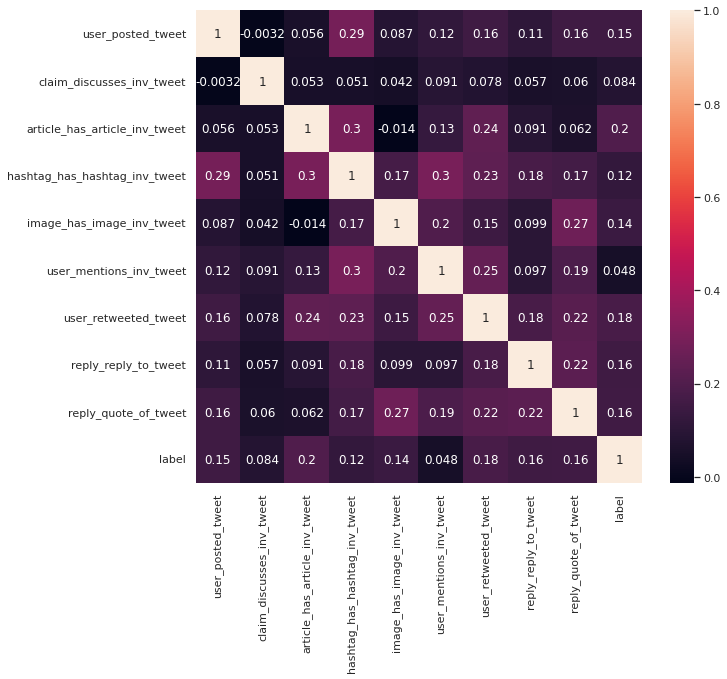

In [ ]:

votings = pd.DataFrame(votings)
votings['label'] = true_label
mat = votings.corr()
ax = sns.heatmap(mat,annot=True)

In [ ]:
#sns.savefig(r"/content/drive/MyDrive/corr_heatmap.png")
ax.figure.savefig(r"/content/drive/MyDrive/corr_heatmap.png")

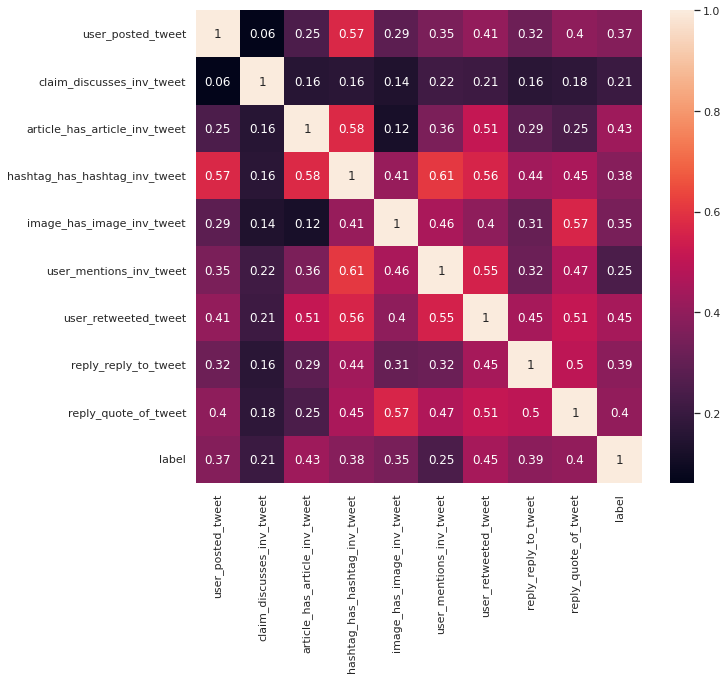

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosmat = copy.deepcopy(mat)
for i in cosmat:
  for j in cosmat.index:
    cosmat.loc[j,i] = cosine_similarity(mat[i].to_numpy().reshape(1, -1), mat[j].to_numpy().reshape(1, -1))
ax2 = sns.heatmap(cosmat,annot=True)

In [ ]:
ax2.figure.savefig(r"/content/drive/MyDrive/cos_heatmap.png")

In [ ]:
for i in cosmat.index:
  print(i)

user_posted_tweet
claim_discusses_inv_tweet
article_has_article_inv_tweet
hashtag_has_hashtag_inv_tweet
image_has_image_inv_tweet
user_mentions_inv_tweet
user_retweeted_tweet
reply_reply_to_tweet
reply_quote_of_tweet


In [ ]:
cosmat.keys()

Index(['user_posted_tweet', 'claim_discusses_inv_tweet',
       'article_has_article_inv_tweet', 'hashtag_has_hashtag_inv_tweet',
       'image_has_image_inv_tweet', 'user_mentions_inv_tweet',
       'user_retweeted_tweet', 'reply_reply_to_tweet', 'reply_quote_of_tweet'],
      dtype='object')

In [ ]:
cosine_similarity(cosmat['user_posted_tweet'].to_numpy().reshape(1, -1), cosmat['claim_discusses_inv_tweet'].to_numpy().reshape(1, -1))

array([[0.04669342]])